# Análisis de datos
> Adrián Felipe Hernández Borda
>
> ---
>
> Universidad Pedagógica y Tccnológica de Colombia 
> Universidad Aurónoma de Sinaloa

---

El presente es un cuaderno de trabajo  y pruebas sobre el proyecto desarrollado en la **optativa de análisis de datos en python**
## Objetivos

Predecir las calificaciones (***Promedio / Matemática, Escritura y Lectura***)  de estudiantes con base a algunas características de su entorno y vida personal

---
## Importar Librerías


In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
sns.set_style(style="ticks")
from os import cpu_count as ncpu
from multiprocessing import Pool as pool
from fitter import Fitter as ftr

## Importar datos
Usando variables de cadenas de caracteres que contienen la ruta del conjunto de datos se importa el csv.

In [3]:
path = "./datasets/"
#file = "global-data-on-sustainable-energy.csv"
file = "Expanded_data_with_more_features.csv"
file_exp = "Original_data_with_more_rows.csv"
full_path = path+file
full_path_exp = path+file_exp
print(f"Dirección del conjunto de datos: '{full_path:s}'")


Dirección del conjunto de datos: './datasets/Expanded_data_with_more_features.csv'


In [4]:
data = pd.read_csv(full_path,sep=",")
sz = data.shape
print(f"Número de variables -> {sz[0]}\nEntradas del conjunto de datos -> {sz[1]}")
print("\n--- CABECERA DEL CONJUNTO DE DATOS ---\n")

display(data.head())

print("\n--- DESCRIPCIÓN ---\n")

display(data.describe())

#data_exp = pd.read_csv(full_path_exp,sep=",")

Número de variables -> 30641
Entradas del conjunto de datos -> 15

--- CABECERA DEL CONJUNTO DE DATOS ---



,ID,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75



--- DESCRIPCIÓN ---



,ID,NrSiblings,MathScore,ReadingScore,WritingScore
count,30641.000000,29069.000000,30641.000000,30641.000000,30641.000000
mean,499.556607,2.145894,66.558402,69.377533,68.418622
std,288.747894,1.458242,15.361616,14.758952,15.443525
min,0.000000,0.000000,0.000000,10.000000,4.000000
25%,249.000000,1.000000,56.000000,59.000000,58.000000
50%,500.000000,2.000000,67.000000,70.000000,69.000000
75%,750.000000,3.000000,78.000000,80.000000,79.000000
max,999.000000,7.000000,100.000000,100.000000,100.000000


---
# Descripción del conjunto de datos

## Variables 
### Categóricas
1. `Gender`
2. `EthnicGroup` 
3. `ParentMaritalStatus`
4. `PracticeSport`
5. `IsFirstChild`
6. `TransportMeans`


### Ordinales
1. `LunchType` **Basado en que la merienda da energía que consume el cerebro**
2. `TestPrep`
3. `ParentEduc` **Basado en el grado de escolaridad**
4. `WklyStudyHours` **Son intervalos de tiempo, no es un número de punto flotante**

### Cuantitativas (Discretas)
1. `ID` **No aporta información para el análisis del conjunto de datos**
2. `NrSiblings`
3. `MathScore`
4. `ReadingScore`
5. `WritingScore` 

## Reescritura del conjunto de datos

Ahora el propósito es asignar a cada valor de una variable categórica un número entero, primero se crea unas funciones que permitan reemplazar los datos de un dataset por números. 

In [5]:
# Función que reemplaza los valores  de acuerdo a como aparezcan al leer de arriba abajo el conjunto de datos

def replace_values(df:pd.DataFrame):
    values = list()
    
    for k in range(len(df)):
        if not pd.isnull(df.iloc[k][df.keys()[0]]):
            if df.iloc[k][df.keys()[0]] not in values:
                values.append(df.iloc[k][df.keys()[0]])
    new_values = [k for k in range(len(values)) ]
    dic = dict(map(lambda x,y:(x,y),values,new_values))
    df = df.replace(to_replace=dic)
    print(f"{df.keys()[0]} -> {dic}")
    return df

# Función que reemplaza una columna de un conjunto de datos

def replace_col(df_main:pd.DataFrame,df_col:pd.DataFrame):
    df_main = df_main.drop(labels=df_col.keys()[0],axis=1)
    df_main = pd.concat([df_main,df_col],axis=1)
    return df_main

Ahora se puede seleccionar las columnas de las variables categóricas  de acuerdo a la inspección previa. Posteriormente el conjunto de datos se puede separar en tres conjuntos más sencillos a los que se aplicará las funciones definidas.

In [6]:
categoric_cols = ["Gender","EthnicGroup","ParentMaritalStatus","PracticeSport","IsFirstChild","TransportMeans"]
ordinal_cols = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"]
cuantitative_cols = ["ID","NrSiblings","MathScore","ReadingScore","WritingScore"]

cols_to_change = [ordinal_cols,categoric_cols]

data_ordinal = data[ordinal_cols]
data_categoric = data[categoric_cols]
data_cuantitative = data[cuantitative_cols]

data_to_change = [data_ordinal,data_categoric]

Una forma de asignar valores numéricos para las variables cuyos valores sons tipo cadena de caracteres es el siguiente:
> No distingue jerarquía para los ordinales

In [7]:
for k in range(len(data_to_change)):
    for cols in cols_to_change[k]:
        data_to_change[k] = replace_col(data_to_change[k],replace_values(data_to_change[k][[cols]]))
    print("\n---\n")
    

LunchType -> {'standard': 0, 'free/reduced': 1}
TestPrep -> {'none': 0, 'completed': 1}
ParentEduc -> {"bachelor's degree": 0, 'some college': 1, "master's degree": 2, "associate's degree": 3, 'high school': 4, 'some high school': 5}
WklyStudyHours -> {'< 5': 0, '5 - 10': 1, '> 10': 2}

---

Gender -> {'female': 0, 'male': 1}
EthnicGroup -> {'group C': 0, 'group B': 1, 'group A': 2, 'group D': 3, 'group E': 4}
ParentMaritalStatus -> {'married': 0, 'single': 1, 'widowed': 2, 'divorced': 3}
PracticeSport -> {'regularly': 0, 'sometimes': 1, 'never': 2}
IsFirstChild -> {'yes': 0, 'no': 1}
TransportMeans -> {'school_bus': 0, 'private': 1}

---



Las variables ordinales toman valores que se mapearon a valores numéricos con base en el algoritmo de identifiación de resultados como sigue

In [8]:
data_ordinal = replace_col(data_ordinal,data_ordinal[["LunchType"]].replace(to_replace={'standard': 1, 'free/reduced': 0}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["WklyStudyHours"]].replace(to_replace={'< 5': 0, '5 - 10': 1, '> 10': 2}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["ParentEduc"]].replace(to_replace={"bachelor's degree": 4, 'some college': 3, "master's degree": 6, "associate's degree": 5, 'high school': 2, 'some high school': 1}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["TestPrep"]].replace(to_replace={'none': 0, 'completed': 1}))

data_new = pd.concat([data_cuantitative,data_ordinal],axis=1)

print("--- CONJUNTO DE DATOS NUMÉRICO ---")
      
display(data_new.head())
data_new.to_csv(path_or_buf="./data_num_new.csv",sep=",")

--- CONJUNTO DE DATOS NUMÉRICO ---


,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep
0,0,3.0,71,71,74,1,0.0,4.0,0.0
1,1,0.0,69,90,88,1,1.0,3.0,NaN
2,2,4.0,87,93,91,1,0.0,6.0,0.0
3,3,1.0,45,56,42,0,1.0,5.0,0.0
4,4,0.0,76,78,75,1,1.0,3.0,0.0


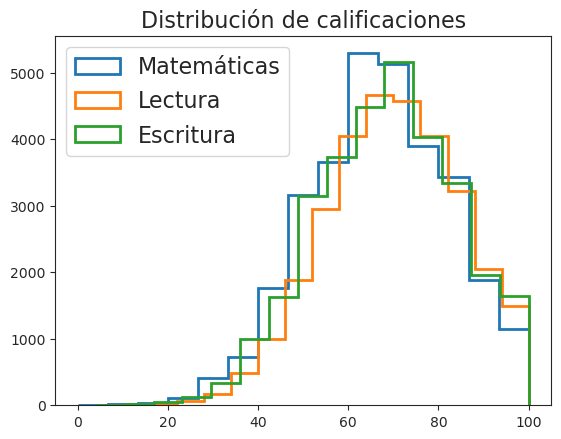

In [9]:
bins = int(1 + np.log2(sz[0]) ) # Regla de Sturges
fntsz = 16

plt.hist(data_new["MathScore"],bins=bins,histtype="step",linewidth=2,label="Matemáticas")
plt.hist(data_new["ReadingScore"],bins=bins,histtype="step",linewidth=2,label="Lectura")
plt.hist(data_new["WritingScore"],bins=bins,histtype="step",linewidth=2,label="Escritura")

plt.title("Distribución de calificaciones",fontsize=fntsz)
plt.legend(fontsize=fntsz)
plt.show()

La distribución entre asignaturas es similar, luego vale al pena pensar en un promedio entre las 3 asignaturas. Otra manera de visualizarlo es encontrando dicho promedio y viendo la correlación entre los datos de las materias y el promedio.

> Descripción de las distribuciones de notas por distribuciones estadísticas.

Ahora la idea es comparar los parámetros de distribución de las calificaciones para evaluar si conviene escribirlas como en promedio de las 3 o separadas. al criterio es, si los parámetros son parecidos, entonces vale la pena describirlas como una sola, en otro acso no.

### Fit de las dostribuciones de notas a distribuciones estadisticas
Con `Fitter` se evaluará cuál distribución estadística es la que mejor ajusta y sobre ella se evaluará los datos.

Para optimizar tiempo usaré `multiprocessing.Pool`

In [15]:
def fits(df:pd.DataFrame):
    f_df = ftt(df)
    f_df.fit()
    return f_df.get_best() 

In [18]:
dfs = [data_cuantitative[["MathScore"]],data_cuantitative[["WritingScore"]],data_cuantitative[["WritingScore"]]]

with pool(ncpu()) as p:
    fit_info = p.map(fits,dfs)


SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED fisk distribution (taking more than 30 seconds)
SKIPPED gausshyper distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED gausshyper distribution (taking more than 30 seconds)
SKIPPED gausshyper distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED genextreme distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED genextreme distribution (taking more than 30 seconds)
SKIPPED genextreme distribution (taking more than 30 seconds)
SKIPPED gengamma distribution (taking more than 30 secon

{'beta': {'a': 8.712477654458723,
  'b': 5.63185921611435,
  'loc': -8.435211431310577,
  'scale': 123.49242250282344}}

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gengamma,0.002625,1148.530664,1181.851041,inf,0.031250,1.979419e-26
gamma,0.002641,1156.409639,1181.399922,inf,0.032026,9.718433e-28
loggamma,0.002657,1092.579675,1117.569958,inf,0.034160,1.688376e-31


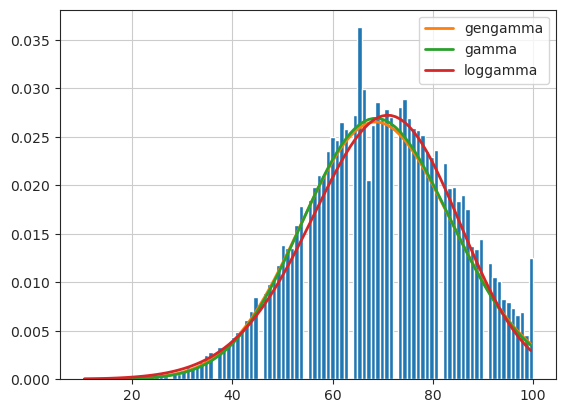

In [27]:

f_math = ftt(data_cuantitative["ReadingScore"],distributions=["gengamma","gamma","loggamma"])
f_math.fit()
f_math.summary()

In [9]:
MeanScore = pd.DataFrame(data={"MeanScore":[np.mean(data_new[["MathScore","ReadingScore","WritingScore"]].iloc[k]) for k in range(sz[0])]})

In [10]:
data_scores = pd.concat([data_new[["MathScore","WritingScore","ReadingScore"]],MeanScore] ,axis=1)

/home/adrian/miniconda3/envs/adat/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


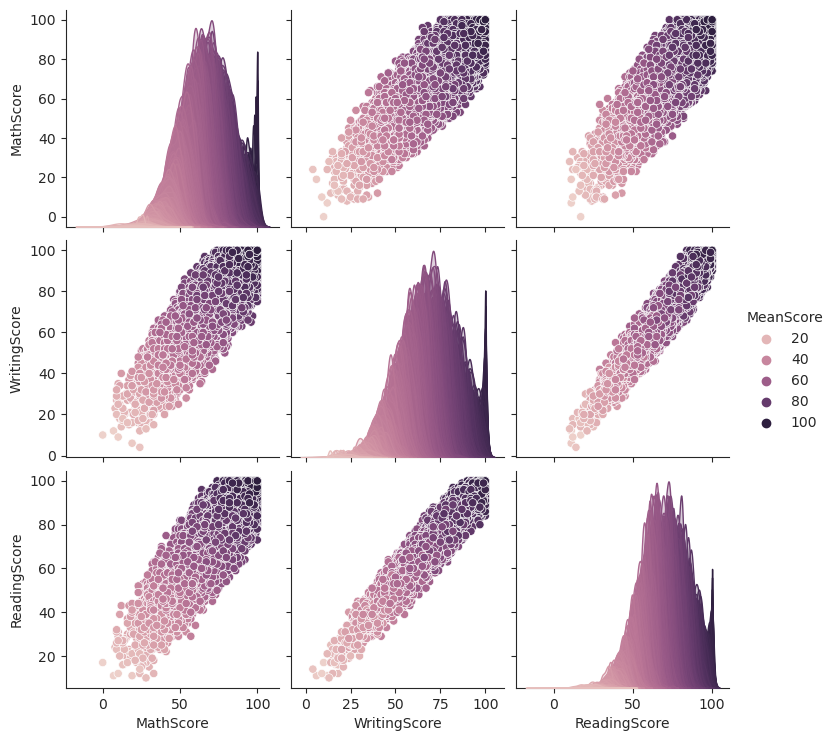

In [11]:
sns.pairplot( data=data_scores,dropna=True,vars=["MathScore","WritingScore","ReadingScore"],hue="MeanScore" )

In [12]:
data_new = data_new.drop(labels=["MathScore","ReadingScore","WritingScore"],axis=1)
data_new = pd.concat([data_new,MeanScore],axis=1)
data_new.head()

,ID,NrSiblings,LunchType,WklyStudyHours,ParentEduc,TestPrep,MeanScore
0,0,3.0,1,0.0,4.0,0.0,72.000000
1,1,0.0,1,1.0,3.0,NaN,82.333333
2,2,4.0,1,0.0,6.0,0.0,90.333333
3,3,1.0,0,1.0,5.0,0.0,47.666667
4,4,0.0,1,1.0,3.0,0.0,76.333333


## Correlación de los datos

La matriz de correlación a continuación muestra 

In [13]:
def corr_matrix (df:pd.DataFrame):
    corr = df.corr()
    sns.heatmap(data=corr,annot=True,cbar=True,cmap="RdYlGn")
corr_matrix(data)
corr_matrix(data_new)

ValueError: could not convert string to float: 'female'

## Variables más relevantes
1. `LunchType`
2. `TestPrep`
3. `ParentEduc`

## Variables menos relevantes
1. `ID`
2. `NrSiblings`
3. `ẀklyStudyHours`


In [ ]:
sns.pairplot(data_new,hue="MeanScore",dropna=True,vars=["LunchType","TestPrep","ParentEduc"])

## Análisis de variables con Scikit-Learn

### importar los módulos de selección

se usará la métrica de $\chi^{2}$, Fisher

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest, f_classif

In [ ]:

'''predict_var = data_new[["MeanScore"]].fillna(np.mean(data_new[["MeanScore"]]))

for col in list(data_new.columns.values):
    data_new = data_new[[col]].fillna(np.mean(data_new[[col]]))
train_set = data_new.drop(labels="MeanScore",axis=1)
n_atrib = 3 
cols = list(data_new.columns.values)

best_vars = SelectKBest(f_classif,k=n_atrib).fit(train_set,predict_var)
'''

In [1]:
## Dont forget

print(pd.get_dummies(data[["ParentEduc"]]).columns.values)

NameError: name 'pd' is not defined